In [312]:
from os.path import join
from os import listdir
from mahotas.features import zernike_moments
import matplotlib.pyplot as plt
import cv2 as cv
import numpy as np
import warnings

warnings.filterwarnings("ignore")

plt.rc('image', cmap='gray')
plt.style.use('dark_background')

# Shape factors tearing of object edges assessment

Where do we need this:

 - identification
 - retrieval (clustering)
 - classification

In [313]:
imgs = [
    cv.imread(join("baza", filename), 0)
    for filename in listdir("baza") if "Segmentation" in filename
]
img = imgs[0]

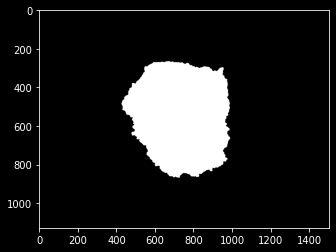

In [314]:
plt.imshow(img)

## Zernike's moments

 - Describes the internal structure of the object
 - Resistant to scaling, rotation and noise
 - Low dimensional representation

 - Average cost of comparisons
 - Very high cost of computing the signature

In [315]:
zernike_moments(img, radius=36)

array([0.31830989, 0.0007855 , 0.00081537, 0.00084849, 0.00160124,
       0.00126547, 0.00133471, 0.00135745, 0.00198987, 0.00247545,
       0.00193207, 0.00151952, 0.0018166 , 0.00177767, 0.00272072,
       0.00292969, 0.00343203, 0.00263451, 0.00207515, 0.0010172 ,
       0.0022442 , 0.00206746, 0.00337997, 0.003548  , 0.0026755 ])

## Fourier descriptors

 - Different FD implementations oriented towards different applications (calculated from different signatures)
 - Describes the contour of the outside
 - 1-D complex version invariant with respect to scaling, rotation and noise

 - Average cost of comparisons
 - Relatively high computational cost due to complex numbers

In [316]:
contour, _ = cv.findContours(img,
    cv.RETR_EXTERNAL,
    cv.CHAIN_APPROX_NONE
)
contour_array = contour[0][:, 0, :]
contour_complex = np.empty(contour_array.shape[:-1], dtype=complex)
contour_complex.real = contour_array[:, 0]
contour_complex.imag = contour_array[:, 1]
fourier_result = np.fft.fft(contour_complex)
fourier_result

array([ 1.52413900e+06+1152198.j        ,
       -1.59030744e+04  -22714.93736286j,
        1.45148749e+04  +24921.82370575j, ...,
       -1.16100662e+03  -21688.88248639j,
       -4.58560718e+03  -10321.7931089j ,
       -1.16698330e+05 -581113.82636414j])

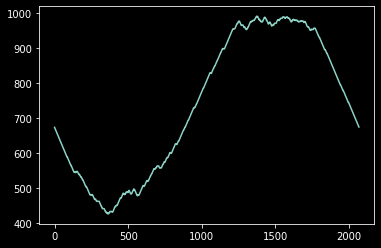

In [317]:
plt.plot(contour_complex)

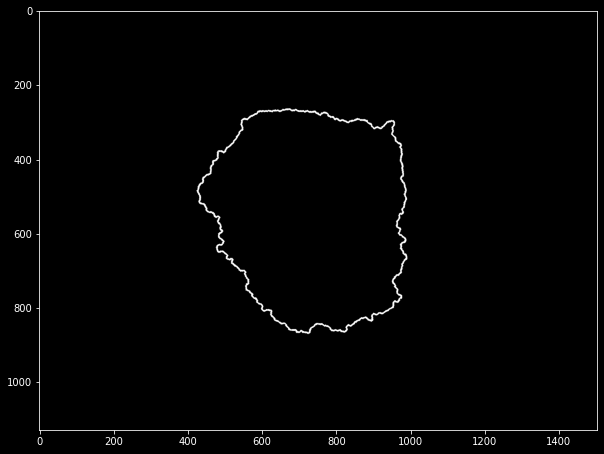

In [318]:
degree = 18 * 1000

descriptors = np.fft.fftshift(fourier_result)
center_index = len(descriptors) / 2

descriptors = descriptors[
              int(center_index - degree / 2):int(center_index + degree / 2)]
descriptors = np.fft.ifftshift(descriptors)

descriptor_in_use = descriptors
contour_reconstruct = np.fft.ifft(descriptor_in_use)
contour_reconstruct = np.array(
    [contour_reconstruct.real, contour_reconstruct.imag])
contour_reconstruct = np.transpose(contour_reconstruct)
contour_reconstruct = np.expand_dims(contour_reconstruct, axis=1)
if contour_reconstruct.min() < 0:
    contour_reconstruct -= contour_reconstruct.min()
x = np.argwhere(img == img.max()).max(axis=0).astype(np.float64)
contour_reconstruct *= x[::-1] / contour_reconstruct.max(axis=0)
contour_reconstruct = contour_reconstruct.astype(np.int32, copy=False)
black = np.zeros_like(img, np.uint8)

cv.drawContours(black, contour_reconstruct, -1, 255, thickness=4)
plt.figure(figsize=(10, 10))
plt.imshow(black)

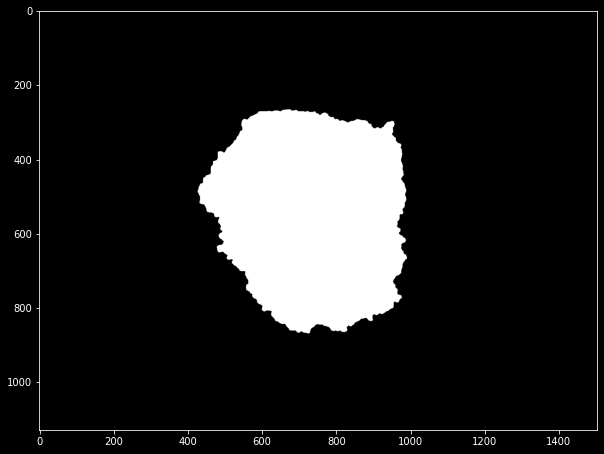

In [319]:
plt.figure(figsize=(10, 10))
plt.imshow(img)